# POD-based Training for Flow Field Reconstruction

This notebook provides training for POD-based flow field reconstruction models using the same methodology as FLRNet and MLP.

**Architecture:**
- Two-stage approach: POD modes extraction + MLP training
- Stage 1: Extract POD modes from training data (offline)
- Stage 2: Train MLP to map sensor data to POD coefficients (online)
- Reconstruction: coefficients × POD modes → full field

**Training Strategy:**
- Unified configuration management (same as MLP/FLRNet)
- Same data preprocessing and loading pipeline
- Advanced callbacks and checkpointing
- Validation and testing workflows

## Imports and Configuration

In [1]:
# Standard imports
import os
import sys
import numpy as np
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import json
import modred as mr

# Local imports (same as FLRNet/MLP)
import config_manager
from data.flow_field_dataset import FlowFieldDatasetCreator
from pod_models import PODReconstructionModel, PODTrainer

# Configure TensorFlow (same as MLP)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

# Enable memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"⚠️ Error setting GPU memory growth: {e}")
else:
    print("🔍 No GPUs found, using CPU")

print(f"TensorFlow version: {tf.__version__}")
print(f"Available devices: {[device.name for device in tf.config.list_logical_devices()]}")

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Environment setup complete!")

Flow Field Dataset Creation Package v1.0.0 loaded successfully!

Quick Start:
  from dataset_creation import FlowFieldDatasetCreator
  creator = FlowFieldDatasetCreator()
  creator.create_all_datasets()

For more info: print_package_info()
✅ GPU memory growth enabled for 1 GPU(s)
TensorFlow version: 2.8.0
Available devices: ['/device:CPU:0', '/device:GPU:0']
✅ Environment setup complete!


## Configuration Loading (Same as FLRNet/MLP)

In [2]:
# Load configuration (exact same pattern as FLRNet/MLP)
config_name = "random_32_standard"  # Available: edge_32_standard, circular_32_standard, random_32_standard, etc.

# Initialize config manager
config_manager_instance = config_manager.ConfigManager("config")

# Load and display configuration
try:
    config = config_manager_instance.load_config(config_name)
    print(f"✅ Successfully loaded configuration: {config_name}")
    
    print("\n📋 Configuration Summary:")
    print("=" * 60)
    print(f"Model Type: POD-based (Sensor → POD coefficients → Field)")
    print(f"Sensor Layout: {config['sensors']['layout']}")
    print(f"Number of Sensors: {config['sensors']['n_sensors']}")
    print(f"Input Shape: {config['model']['input_shape']}")
    print(f"Batch Size: {config['training']['batch_size']}")
    print(f"Dataset Path: {config.get('dataset_path', 'Will be created')}")
    print(f"Checkpoint Dir: {config['checkpoint_dir']}")
    print(f"Logs Dir: {config['logs_dir']}")
    print(f"Model Name: {config['model_name']}")
    
    # Extract key parameters for POD training
    n_sensors = config['sensors']['n_sensors']
    sensor_layout = config['sensors']['layout']
    input_shape = tuple(config['model']['input_shape'])
    batch_size = config['training']['batch_size']
    
    print("\n✅ Configuration loaded successfully!")
    
except Exception as e:
    print(f"❌ Error loading configuration: {e}")
    print("Available configurations:")
    try:
        available_configs = config_manager_instance.list_configs()
        for cfg in available_configs:
            print(f"  - {cfg}")
    except:
        print("  Could not list available configurations")
    raise

✅ Successfully loaded configuration: random_32_standard

📋 Configuration Summary:
Model Type: POD-based (Sensor → POD coefficients → Field)
Sensor Layout: random
Number of Sensors: 32
Input Shape: [128, 256, 1]
Batch Size: 8
Dataset Path: data/datasets\dataset_random_32.npz
Checkpoint Dir: ./checkpoints\fourierTrue_percepTrue_random_32
Logs Dir: ./logs\fourierTrue_percepTrue_random_32
Model Name: fourierTrue_percepTrue_random_32

✅ Configuration loaded successfully!


## Dataset Creation and Loading (Same as FLRNet/MLP)

In [3]:
# Load and prepare dataset created from data_creation_and_viz.ipynb (same as FLRNet/MLP)
print(f"📁 Loading dataset from: {config['dataset_path']}")

# Parse the dataset filename to get layout and n_sensors
dataset_filename = Path(config['dataset_path']).name
# Expected format: dataset_edge_32.npz
parts = dataset_filename.split('_')
layout_type = parts[1]  # 'edge'
n_sensors = int(parts[2].split('.')[0])  # 32

print(f"📊 Dataset parameters:")
print(f"   Layout type: {layout_type}")
print(f"   Number of sensors: {n_sensors}")

# Load the dataset directly from the NPZ file
print(f"📁 Loading dataset file: {config['dataset_path']}")
data = np.load(config['dataset_path'])

# Check what keys are available in the dataset
print(f"📋 Available keys in dataset: {list(data.keys())}")

# Create dataset dictionary
dataset = {key: data[key] for key in data.keys()}

# Print dataset information
print(f"📊 Dataset loaded successfully:")
for key, value in dataset.items():
    if isinstance(value, np.ndarray):
        print(f"   {key}: {value.shape} ({value.dtype})")
    else:
        print(f"   {key}: {value}")

# Extract sensor positions
sensor_positions = dataset['sensor_positions']
print(f"📍 Sensor positions shape: {sensor_positions.shape}")

# Create dataset creator instance for TensorFlow dataset creation
creator = FlowFieldDatasetCreator(
    output_path="./data/",
    domain_shape=input_shape,  # (height, width)
    use_synthetic_data=False  # Don't create synthetic data, just use for TF dataset creation
)

# Create TensorFlow datasets using the creator's method
train_dataset, test_dataset = creator.create_tensorflow_dataset(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    test_split=config['training']['test_split']
)

print(f"\n📊 TensorFlow datasets created:")
print(f"   Train dataset: {train_dataset}")
print(f"   Test dataset: {test_dataset}")

# Function to add coordinate grids to field data for coordinate-aware training
def add_coordinate_grid(batch):
    """Add coordinate grid to field data for coordinate-aware training"""
    field_data = batch['field_data']
    
    # Get dimensions
    batch_size = tf.shape(field_data)[0]
    height = tf.shape(field_data)[1]
    width = tf.shape(field_data)[2]
    
    # Create normalized coordinate grids [0, 1] - match field dimensions
    x_coords = tf.linspace(0.0, 1.0, width)   # Width corresponds to x
    y_coords = tf.linspace(0.0, 1.0, height)  # Height corresponds to y
    
    # Create meshgrid to match image indexing: [height, width, 2]
    y_grid, x_grid = tf.meshgrid(y_coords, x_coords, indexing='ij')
    
    # Stack to create coordinate grid (height, width, 2)
    coord_grid = tf.stack([x_grid, y_grid], axis=-1)
    
    # Expand to batch size (batch_size, height, width, 2)
    coord_batch = tf.tile(tf.expand_dims(coord_grid, 0), [batch_size, 1, 1, 1])
    
    # Update batch to include coordinates
    return {
        'field_data': field_data,
        'sensor_data': batch['sensor_data'],
        'coordinates': coord_batch
    }

# Add coordinate grids to datasets
coord_train_dataset = train_dataset.map(add_coordinate_grid)
coord_test_dataset = test_dataset.map(add_coordinate_grid)

print(f"\n📊 Coordinate-aware datasets created:")
print(f"   Train dataset with coordinates: {coord_train_dataset}")
print(f"   Test dataset with coordinates: {coord_test_dataset}")

# Get a sample to verify data shapes
print(f"\n📊 Data shape verification:")
for batch in coord_train_dataset.take(1):
    print(f"   Sensor data shape: {batch['sensor_data'].shape}")
    print(f"   Field data shape: {batch['field_data'].shape}")
    print(f"   Coordinates shape: {batch['coordinates'].shape}")
    break

📁 Loading dataset from: data/datasets\dataset_random_32.npz
📊 Dataset parameters:
   Layout type: random
   Number of sensors: 32
📁 Loading dataset file: data/datasets\dataset_random_32.npz
📋 Available keys in dataset: ['sensor_data', 'field_data', 'sensor_positions', 'reynolds_numbers', 'layout_type', 'n_sensors']
📊 Dataset loaded successfully:
   sensor_data: (28, 32, 39) (float64)
   field_data: (28, 128, 256, 39) (float64)
   sensor_positions: (32, 2) (float64)
   reynolds_numbers: (28,) (int32)
   layout_type: () (<U6)
   n_sensors: () (int32)
📍 Sensor positions shape: (32, 2)
📊 Dataset Creator initialized:
   Domain shape: (128, 256, 1)
   Caching: ✅ ENABLED
   Cache directory: data\cache
Dataset reshaped:
  Original sensor data: (28, 32, 39)
  Reshaped sensor data: (1092, 32)
  Original field data: (28, 128, 256, 39)
  Reshaped field data: (1092, 128, 256, 1)
  Total samples: 1092
TensorFlow datasets created:
  Train samples: 873
  Test samples: 219

📊 TensorFlow datasets create

## POD Mode Extraction (NEW - Key difference from MLP/FLRNet)

In [4]:
# POD Mode Extraction Phase
print("🔧 POD Mode Extraction Phase")
print("=" * 50)

# Parameters for POD
n_pod_modes = 256  # Number of POD modes to extract
pod_modes_filename = f"pod_modes_{n_pod_modes}_revised.npy"

# Initialize POD trainer
model_name = f"pod_{config['model_name']}"
pod_trainer = PODTrainer(
    input_shape=input_shape,
    checkpoint_dir=config['checkpoint_dir'],
    logs_dir=config['logs_dir'],
    model_name=model_name
)

# Extract field data for POD analysis
print("📊 Extracting field data from training dataset...")
field_data_list = []
sensor_data_list = []

# Collect all training data
for batch in coord_train_dataset:
    field_data_list.append(batch['field_data'].numpy())
    sensor_data_list.append(batch['sensor_data'].numpy())

# Concatenate all data
all_field_data = np.concatenate(field_data_list, axis=0)
all_sensor_data = np.concatenate(sensor_data_list, axis=0)

print(f"📊 Collected training data:")
print(f"   Field data shape: {all_field_data.shape}")
print(f"   Sensor data shape: {all_sensor_data.shape}")

# Check if POD modes file already exists
pod_modes_path = Path(pod_modes_filename)
if pod_modes_path.exists():
    print(f"📁 Found existing POD modes file: {pod_modes_filename}")
    print(f"🔄 Loading existing POD modes...")
    
    try:
        pod_modes = np.load(pod_modes_filename)
        print(f"✅ POD modes loaded successfully!")
        print(f"   POD modes shape: {pod_modes.shape}")
        print(f"   Expected shape: ({np.prod(input_shape)}, {n_pod_modes})")
        
        # Verify loaded POD modes shape
        expected_shape = (np.prod(input_shape), n_pod_modes)
        if pod_modes.shape != expected_shape:
            print(f"⚠️  Shape mismatch! Expected {expected_shape}, got {pod_modes.shape}")
            print(f"🔄 Recomputing POD modes...")
            raise ValueError("Shape mismatch - will recompute")
        
        # Set POD modes in trainer
        pod_trainer.pod_modes = pod_modes
        
    except Exception as e:
        print(f"❌ Error loading POD modes: {e}")
        print(f"🔄 Computing POD modes from scratch...")
        
        # Extract POD modes
        pod_modes = pod_trainer.extract_pod_modes(
            field_data=all_field_data,
            n_modes=n_pod_modes,
            save_path=pod_modes_filename
        )
        
else:
    print(f"📁 POD modes file not found: {pod_modes_filename}")
    print(f"🔄 Computing POD modes from scratch...")
    
    # Extract POD modes
    pod_modes = pod_trainer.extract_pod_modes(
        field_data=all_field_data,
        n_modes=n_pod_modes,
        save_path=pod_modes_filename
    )

print(f"✅ POD modes ready!")
print(f"   POD modes shape: {pod_modes.shape}")
print(f"   Saved to: {pod_modes_filename}")

# Verify POD modes
print(f"\n🔍 POD modes verification:")
print(f"   Expected shape: ({np.prod(input_shape)}, {n_pod_modes})")
print(f"   Actual shape: {pod_modes.shape}")
print(f"   Field flattened size: {np.prod(input_shape)}")
print(f"   Compression ratio: {np.prod(input_shape) / n_pod_modes:.1f}x")

# Additional verification: Check if POD modes are valid
print(f"\n🔍 POD modes statistics:")
print(f"   - Mean: {np.mean(pod_modes):.6f}")
print(f"   - Std: {np.std(pod_modes):.6f}")
print(f"   - Range: [{np.min(pod_modes):.6f}, {np.max(pod_modes):.6f}]")
print(f"   - Contains NaN: {np.isnan(pod_modes).any()}")
print(f"   - Contains Inf: {np.isinf(pod_modes).any()}")

if np.isnan(pod_modes).any() or np.isinf(pod_modes).any():
    print(f"⚠️  POD modes contain invalid values!")
    raise ValueError("POD modes contain NaN or Inf values")

print(f"✅ POD modes verification passed!")

🔧 POD Mode Extraction Phase
📊 Extracting field data from training dataset...
📊 Collected training data:
   Field data shape: (873, 128, 256, 1)
   Sensor data shape: (873, 32)
📁 Found existing POD modes file: pod_modes_256_revised.npy
🔄 Loading existing POD modes...
✅ POD modes loaded successfully!
   POD modes shape: (32768, 256)
   Expected shape: (32768, 256)
✅ POD modes ready!
   POD modes shape: (32768, 256)
   Saved to: pod_modes_256_revised.npy

🔍 POD modes verification:
   Expected shape: (32768, 256)
   Actual shape: (32768, 256)
   Field flattened size: 32768
   Compression ratio: 128.0x

🔍 POD modes statistics:
   - Mean: 0.000017
   - Std: 0.005524
   - Range: [-0.075109, 0.082330]
   - Contains NaN: False
   - Contains Inf: False
✅ POD modes verification passed!


## Compute POD Coefficients (NEW - Training target generation)

In [5]:
# Computing POD Coefficients for Training
print("🔧 Computing POD Coefficients for Training")
print("=" * 50)

# Compute POD coefficients for training data
pod_coefficients = pod_trainer.compute_pod_coefficients(
    field_data=all_field_data,
    pod_modes=pod_modes
)

print(f"✅ POD coefficients computed:")
print(f"   Coefficients shape: {pod_coefficients.shape}")
print(f"   Expected shape: ({all_field_data.shape[0]}, {n_pod_modes})")

# Verify reconstruction capability
print(f"\n🔍 Verifying POD reconstruction...")
# Test reconstruction: coefficients @ modes^T
test_reconstruction = np.matmul(pod_coefficients[:3], pod_modes.T)
test_reconstruction = test_reconstruction.reshape(3, *input_shape)
original_samples = all_field_data[:3]

reconstruction_error = np.mean((original_samples - test_reconstruction)**2)
print(f"   Reconstruction MSE: {reconstruction_error:.6f}")
print(f"   Original range: [{np.min(original_samples):.6f}, {np.max(original_samples):.6f}]")
print(f"   Reconstructed range: [{np.min(test_reconstruction):.6f}, {np.max(test_reconstruction):.6f}]")

if reconstruction_error < 1e-10:
    print(f"   ✅ POD reconstruction verification successful!")
else:
    print(f"   ⚠️ POD reconstruction error: {reconstruction_error:.6e}")

print(f"\n📊 POD coefficients statistics:")
print(f"   - Mean: {np.mean(pod_coefficients):.6f}")
print(f"   - Std: {np.std(pod_coefficients):.6f}")
print(f"   - Range: [{np.min(pod_coefficients):.6f}, {np.max(pod_coefficients):.6f}]")

# Create POD training dataset: (sensor_data, pod_coefficients)
print("\n🔄 Creating POD training datasets...")

# Create training and validation split
val_split = config['training']['test_split']
total_samples = len(all_sensor_data)
val_samples = int(val_split * total_samples)

# Create validation dataset
val_indices = np.random.choice(total_samples, val_samples, replace=False)
train_indices = np.setdiff1d(np.arange(total_samples), val_indices)

train_sensor_data = all_sensor_data[train_indices]
train_pod_coefficients = pod_coefficients[train_indices]
val_sensor_data = all_sensor_data[val_indices]
val_pod_coefficients = pod_coefficients[val_indices]

print(f"📊 Dataset split:")
print(f"   Total samples: {total_samples}")
print(f"   Training samples: {len(train_indices)}")
print(f"   Validation samples: {len(val_indices)}")

# Create TensorFlow datasets for POD training
pod_train_dataset = tf.data.Dataset.from_tensor_slices((train_sensor_data, train_pod_coefficients))
pod_train_dataset = pod_train_dataset.shuffle(buffer_size=1000).batch(batch_size)

pod_val_dataset = tf.data.Dataset.from_tensor_slices((val_sensor_data, val_pod_coefficients))
pod_val_dataset = pod_val_dataset.batch(batch_size)

print(f"✅ POD training datasets created:")
print(f"   Train dataset: {pod_train_dataset}")
print(f"   Validation dataset: {pod_val_dataset}")

# Verify dataset structure
print(f"\n🔍 POD dataset structure verification:")
for pod_batch in pod_train_dataset.take(1):
    sensor_inputs, coeff_targets = pod_batch
    print(f"   POD sensor input shape: {sensor_inputs.shape}")
    print(f"   POD coefficient target shape: {coeff_targets.shape}")
    break

🔧 Computing POD Coefficients for Training
🔧 Computing POD coefficients...
✅ POD coefficients computed: (873, 256)
📈 POD coefficients statistics:
   - Mean: 0.786170
   - Std: 12.954432
   - Range: [-60.977486, 221.631378]
✅ POD coefficients computed:
   Coefficients shape: (873, 256)
   Expected shape: (873, 256)

🔍 Verifying POD reconstruction...
   Reconstruction MSE: 0.000036
   Original range: [0.000000, 1.732190]
   Reconstructed range: [-0.028067, 1.725704]
   ⚠️ POD reconstruction error: 3.552292e-05

📊 POD coefficients statistics:
   - Mean: 0.786170
   - Std: 12.954432
   - Range: [-60.977486, 221.631378]

🔄 Creating POD training datasets...
📊 Dataset split:
   Total samples: 873
   Training samples: 699
   Validation samples: 174
✅ POD training datasets created:
   Train dataset: <BatchDataset element_spec=(TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256), dtype=tf.float32, name=None))>
   Validation dataset: <BatchDataset element_spec=(

## POD Model Training (NEW - MLP to predict coefficients)

In [6]:
# Training POD-based Reconstruction Model
print("🚀 Training POD-based Reconstruction Model")
print("=" * 50)

# POD model configuration
pod_config = {
    'n_sensors': n_sensors,
    'n_pod_modes': n_pod_modes,
    'hidden_layers': [256, 512, 512, 256],  # Smaller than direct MLP since output is compressed
    'activation': 'relu',
    'dropout_rate': 0.2,
    'use_batch_norm': True,
}

# Training configuration
training_config = {
    'epochs': 200,
    'learning_rate': 1e-4,  # Lower learning rate for stable coefficient prediction
    'patience': 20,
    'reduce_lr_patience': 8,
}

print(f"📋 POD Model Configuration:")
for key, value in pod_config.items():
    print(f"  {key}: {value}")

print(f"\n🎯 Training Configuration:")
for key, value in training_config.items():
    print(f"  {key}: {value}")

print(f"\n💡 Key Architecture Differences from Direct MLP:")
print(f"  - Output size: {n_pod_modes} coefficients (vs {np.prod(input_shape)} pixels)")
print(f"  - Compression ratio: {np.prod(input_shape) / n_pod_modes:.1f}x")
print(f"  - Training target: POD coefficients (vs raw field data)")
print(f"  - Reconstruction: coefficients × POD modes (vs direct neural output)")



🚀 Training POD-based Reconstruction Model
📋 POD Model Configuration:
  n_sensors: 32
  n_pod_modes: 256
  hidden_layers: [256, 512, 512, 256]
  activation: relu
  dropout_rate: 0.2
  use_batch_norm: True

🎯 Training Configuration:
  epochs: 200
  learning_rate: 0.0001
  patience: 20
  reduce_lr_patience: 8

💡 Key Architecture Differences from Direct MLP:
  - Output size: 256 coefficients (vs 32768 pixels)
  - Compression ratio: 128.0x
  - Training target: POD coefficients (vs raw field data)
  - Reconstruction: coefficients × POD modes (vs direct neural output)


In [7]:
# # Train POD model
# pod_model = pod_trainer.train_pod_model(
#     train_dataset=pod_train_dataset,
#     val_dataset=pod_val_dataset,
#     n_sensors=pod_config['n_sensors'],
#     n_pod_modes=pod_config['n_pod_modes'],
#     pod_modes=pod_modes,
#     epochs=training_config['epochs'],
#     learning_rate=training_config['learning_rate'],
#     hidden_layers=pod_config['hidden_layers'],
#     activation=pod_config['activation'],
#     dropout_rate=pod_config['dropout_rate'],
#     use_batch_norm=pod_config['use_batch_norm'],
#     patience=training_config['patience'],
#     reduce_lr_patience=training_config['reduce_lr_patience']
# )

# print(f"\n✅ POD model training completed!")

## Model Evaluation and Testing (NEW - POD reconstruction)

In [8]:
# # Evaluating POD-based Reconstruction Model
# print("🧪 Evaluating POD-based Reconstruction Model")
# print("=" * 50)

# # Test on some samples
# print("🔮 Generating POD reconstructions...")

# # Get test data
# test_batch = next(iter(coord_test_dataset))
# test_sensor_data = test_batch['sensor_data'][:5]  # First 5 samples
# test_field_data = test_batch['field_data'][:5]

# print(f"📊 Test data shapes:")
# print(f"   Test sensor data: {test_sensor_data.shape}")
# print(f"   Test field data: {test_field_data.shape}")

# # Test coefficient prediction
# predicted_coefficients = pod_model.predict_coefficients(test_sensor_data)
# print(f"   Predicted coefficients: {predicted_coefficients.shape}")

# # Test full reconstruction
# predictions = pod_model(test_sensor_data, training=False)
# print(f"   Full reconstructions: {predictions.shape}")

# # Calculate metrics
# mse = tf.reduce_mean(tf.square(test_field_data - predictions))
# mae = tf.reduce_mean(tf.abs(test_field_data - predictions))
# rmse = tf.sqrt(mse)

# print(f"\n📊 Test Results:")
# print(f"  MSE: {mse:.6f}")
# print(f"  MAE: {mae:.6f}")
# print(f"  RMSE: {rmse:.6f}")

# # Compare with POD reconstruction limits
# print(f"\n🔍 POD Reconstruction Analysis:")
# # Compute true coefficients for test data
# test_field_flat = test_field_data.numpy().reshape(test_field_data.shape[0], -1)
# true_coefficients = np.matmul(test_field_flat, pod_modes)
# ideal_reconstruction = np.matmul(true_coefficients, pod_modes.T)
# ideal_reconstruction = ideal_reconstruction.reshape(test_field_data.shape)

# ideal_mse = np.mean((test_field_data.numpy() - ideal_reconstruction)**2)
# print(f"  Ideal POD MSE (theoretical limit): {ideal_mse:.6f}")
# print(f"  Actual model MSE: {mse:.6f}")
# print(f"  MSE ratio (model/ideal): {mse/ideal_mse:.2f}")

# # Coefficient prediction accuracy
# coeff_mse = np.mean((true_coefficients - predicted_coefficients.numpy())**2)
# coeff_mae = np.mean(np.abs(true_coefficients - predicted_coefficients.numpy()))
# print(f"  Coefficient MSE: {coeff_mse:.6f}")
# print(f"  Coefficient MAE: {coeff_mae:.6f}")

# print(f"\n✅ Evaluation completed!")

## Results Visualization (NEW - POD-specific visualization)

In [9]:
# # POD-specific visualization
# def visualize_pod_results(idx, predictions, targets, sensors, coefficients, true_coefficients, title_suffix=""):
#     """Visualize POD reconstruction results."""
#     fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
#     # Ground truth
#     im1 = axes[0, 0].imshow(targets[idx, :, :, 0], cmap='Spectral_r', vmin=0, vmax=1)
#     axes[0, 0].set_title('Ground Truth')
#     axes[0, 0].axis('off')
#     plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
    
#     # POD reconstruction
#     im2 = axes[0, 1].imshow(predictions[idx, :, :, 0], cmap='Spectral_r', vmin=0, vmax=1)
#     axes[0, 1].set_title('POD Reconstruction')
#     axes[0, 1].axis('off')
#     plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
#     # Error map
#     error = np.abs(targets[idx, :, :, 0] - predictions[idx, :, :, 0])
#     im3 = axes[0, 2].imshow(error, cmap='Reds', vmin=0, vmax=np.max(error))
#     axes[0, 2].set_title('Absolute Error')
#     axes[0, 2].axis('off')
#     plt.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)
    
#     # POD coefficients comparison
#     mode_indices = np.arange(len(coefficients[idx]))
#     axes[0, 3].bar(mode_indices - 0.2, true_coefficients[idx], 0.4, label='True', alpha=0.7)
#     axes[0, 3].bar(mode_indices + 0.2, coefficients[idx], 0.4, label='Predicted', alpha=0.7)
#     axes[0, 3].set_title(f'POD Coefficients Comparison')
#     axes[0, 3].set_xlabel('Mode Index')
#     axes[0, 3].set_ylabel('Coefficient Value')
#     axes[0, 3].legend()
#     axes[0, 3].grid(True, alpha=0.3)
    
#     # Sensor readings
#     axes[1, 0].bar(range(len(sensors[idx])), sensors[idx])
#     axes[1, 0].set_title(f'Sensor Readings ({len(sensors[idx])} sensors)')
#     axes[1, 0].set_xlabel('Sensor Index')
#     axes[1, 0].set_ylabel('Normalized Value')
#     axes[1, 0].grid(True, alpha=0.3)
    
#     # Correlation plot
#     target_flat = targets[idx, :, :, 0].flatten()
#     pred_flat = predictions[idx, :, :, 0].flatten()
#     axes[1, 1].scatter(target_flat, pred_flat, alpha=0.3, s=1)
#     axes[1, 1].plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
#     axes[1, 1].set_xlabel('Ground Truth')
#     axes[1, 1].set_ylabel('Prediction')
#     axes[1, 1].set_title('Prediction vs Truth')
#     axes[1, 1].legend()
#     axes[1, 1].grid(True, alpha=0.3)
    
#     # Coefficient correlation
#     axes[1, 2].scatter(true_coefficients[idx], coefficients[idx], alpha=0.7)
#     axes[1, 2].plot([np.min(true_coefficients[idx]), np.max(true_coefficients[idx])], 
#                    [np.min(true_coefficients[idx]), np.max(true_coefficients[idx])], 'r--')
#     axes[1, 2].set_xlabel('True Coefficients')
#     axes[1, 2].set_ylabel('Predicted Coefficients')
#     axes[1, 2].set_title('Coefficient Correlation')
#     axes[1, 2].grid(True, alpha=0.3)
    
#     # Metrics
#     mse_val = np.mean((targets[idx] - predictions[idx])**2)
#     mae_val = np.mean(np.abs(targets[idx] - predictions[idx]))
#     r2_val = 1 - np.sum((target_flat - pred_flat)**2) / np.sum((target_flat - np.mean(target_flat))**2)
#     coeff_mse = np.mean((true_coefficients[idx] - coefficients[idx])**2)
    
#     axes[1, 3].text(0.1, 0.8, f'Field MSE: {mse_val:.6f}', fontsize=12, transform=axes[1, 3].transAxes)
#     axes[1, 3].text(0.1, 0.6, f'Field MAE: {mae_val:.6f}', fontsize=12, transform=axes[1, 3].transAxes)
#     axes[1, 3].text(0.1, 0.4, f'Field R²: {r2_val:.4f}', fontsize=12, transform=axes[1, 3].transAxes)
#     axes[1, 3].text(0.1, 0.2, f'Coeff MSE: {coeff_mse:.6f}', fontsize=12, transform=axes[1, 3].transAxes)
#     axes[1, 3].text(0.1, 0.0, f'POD Modes: {len(coefficients[idx])}', fontsize=12, transform=axes[1, 3].transAxes)
#     axes[1, 3].set_title('Reconstruction Metrics')
#     axes[1, 3].axis('off')
    
#     plt.suptitle(f'POD-based Flow Field Reconstruction - Sample {idx+1}{title_suffix}', fontsize=16)
#     plt.tight_layout()
#     plt.show()

# # Visualize results
# print("🎨 Visualizing POD reconstruction results...")

# # Convert to numpy for visualization
# predictions_np = predictions.numpy()
# targets_np = test_field_data.numpy()
# sensors_np = test_sensor_data.numpy()
# coefficients_np = predicted_coefficients.numpy()

# # Compute true coefficients for comparison
# true_coefficients_np = true_coefficients[:5]  # First 5 samples

# print(f"📊 Visualization data shapes:")
# print(f"   Predictions: {predictions_np.shape}")
# print(f"   Targets: {targets_np.shape}")
# print(f"   Sensors: {sensors_np.shape}")
# print(f"   Predicted coefficients: {coefficients_np.shape}")
# print(f"   True coefficients: {true_coefficients_np.shape}")

# # Visualize first 3 samples
# for i in range(3):
#     print(f"\n📊 Visualizing sample {i+1}/3:")
#     visualize_pod_results(i, predictions_np, targets_np, sensors_np, coefficients_np, true_coefficients_np,
#                          title_suffix=f" ({config_name})")

# print("\n✅ Visualization completed!")

## Save Results and Generate Report

In [10]:
# # Save POD model results and generate report
# print("💾 Saving POD model results...")

# # Save POD modes for future use
# modes_save_path = f"pod_modes_{n_pod_modes}_{config_name}.npy"
# np.save(modes_save_path, pod_modes)
# print(f"✅ POD modes saved to: {modes_save_path}")

# # Save model configuration
# config_save_path = f"pod_config_{config_name}.json"
# pod_model_config = {
#     'model_type': 'POD-based',
#     'n_sensors': n_sensors,
#     'n_pod_modes': n_pod_modes,
#     'input_shape': input_shape,
#     'hidden_layers': pod_config['hidden_layers'],
#     'activation': pod_config['activation'],
#     'dropout_rate': pod_config['dropout_rate'],
#     'use_batch_norm': pod_config['use_batch_norm'],
#     'total_parameters': int(total_params),
#     'trainable_parameters': int(trainable_params),
#     'compression_ratio': float(np.prod(input_shape) / n_pod_modes),
#     'training_epochs': training_config['epochs'],
#     'learning_rate': training_config['learning_rate'],
#     'sensor_layout': layout_type,
#     'config_name': config_name
# }

# with open(config_save_path, 'w') as f:
#     json.dump(pod_model_config, f, indent=2)
# print(f"✅ Model configuration saved to: {config_save_path}")

# # Generate summary report
# print(f"\n📋 POD MODEL SUMMARY REPORT")
# print("=" * 60)
# print(f"Model Type: POD-based Reconstruction")
# print(f"Configuration: {config_name}")
# print(f"Sensor Layout: {layout_type} ({n_sensors} sensors)")
# print(f"Field Shape: {input_shape}")
# print(f"POD Modes: {n_pod_modes}")
# print(f"Compression Ratio: {np.prod(input_shape) / n_pod_modes:.1f}x")
# print(f"Model Parameters: {total_params:,}")
# print(f"Model Size: {total_params * 4 / (1024**2):.2f} MB")
# print(f"Training Epochs: {training_config['epochs']}")
# print(f"Learning Rate: {training_config['learning_rate']}")
# print(f"Test MSE: {mse:.6f}")
# print(f"Test MAE: {mae:.6f}")
# print(f"Test RMSE: {rmse:.6f}")
# print(f"Coefficient MSE: {coeff_mse:.6f}")
# print(f"Ideal POD MSE: {ideal_mse:.6f}")
# print(f"MSE Ratio (model/ideal): {mse/ideal_mse:.2f}")

# print(f"\n✅ POD training and evaluation completed!")
# print(f"📁 Files saved:")
# print(f"   - POD modes: {modes_save_path}")
# print(f"   - Model config: {config_save_path}")
# print(f"   - Model weights: {pod_trainer.checkpoint_dir}")
# print(f"   - Training logs: {pod_trainer.logs_dir}")

## Load Existing Model (Optional)

In [11]:
# Load existing POD model from checkpoint (uncomment to use)
print("🔄 Loading existing POD model...")

# Load POD modes
try:
    loaded_pod_modes = np.load(f"pod_modes_{n_pod_modes}_revised.npy")
    print(f"✅ POD modes loaded: {loaded_pod_modes.shape}")
except FileNotFoundError:
    print("❌ POD modes file not found. Using current pod_modes.")
    loaded_pod_modes = pod_modes

# Initialize trainer for loading
loader = PODTrainer(
    input_shape=input_shape,
    checkpoint_dir=config['checkpoint_dir'],
    logs_dir=config['logs_dir'],
    model_name=model_name
)

# Load model
loaded_pod_model = loader.load_pod_from_checkpoint(
    n_sensors=n_sensors,
    n_pod_modes=n_pod_modes,
    pod_modes=loaded_pod_modes,
    hidden_layers=pod_config['hidden_layers'],
    activation=pod_config['activation'],
    dropout_rate=pod_config['dropout_rate'],
    use_batch_norm=pod_config['use_batch_norm'],
    checkpoint_name="best"
)

if loaded_pod_model is not None:
    print("✅ POD model loaded successfully!")
   
    # # Optional: Continue training
    # continued_model = pod_trainer.train_pod_model(
    #     train_dataset=pod_train_dataset,
    #     val_dataset=pod_val_dataset,
    #     n_sensors=n_sensors,
    #     n_pod_modes=n_pod_modes,
    #     pod_modes=loaded_pod_modes,
    #     epochs=50,
    #     learning_rate=1e-5,
    #     patience=10
    # )
else:
    print("❌ Failed to load POD model from checkpoint")

print("💡 To continue training, uncomment the code above")

🔄 Loading existing POD model...
✅ POD modes loaded: (32768, 256)
🔄 Loading POD model from checkpoint...
✅ POD modes set: (32768, 256)
✅ POD model loaded from: checkpoints\fourierTrue_percepTrue_random_32\checkpoint_pod_fourierTrue_percepTrue_random_32_pod_best
✅ POD model loaded successfully!
💡 To continue training, uncomment the code above


In [12]:
# # POD Inference on Test Dataset with Custom Reshaping to (8, 128, 256, 39)
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# from pathlib import Path
# import time

# print("🔮 === POD TEST DATASET INFERENCE ===")
# print("=" * 60)

# # Configuration for inference
# save_results = True  # Set to True to save reconstruction results
# visualize_samples = True  # Set to True to show visualizations
# n_visualization_samples = 6  # Number of samples to visualize
# save_format = 'npz'  # Options: 'npz', 'npy', 'both'
# results_dir = Path(config['checkpoint_dir']).parent / "inference_results"

# # Target reshape dimensions - FIXED DIMENSIONS
# TARGET_CASES = 8
# TARGET_HEIGHT = 128
# TARGET_WIDTH = 256
# TARGET_TIME = 39

# print(f"🎯 Target reshape: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")

# # Create results directory
# if save_results:
#     results_dir.mkdir(exist_ok=True)
#     print(f"📁 Results will be saved to: {results_dir}")

# # Check if POD model is available
# if 'loaded_pod_model' in locals() and loaded_pod_model is not None:
#     pod_model_for_inference = loaded_pod_model
#     pod_modes_for_inference = loaded_pod_modes
#     print(f"✅ Using loaded POD model for inference")
# elif 'pod_model' in locals() and pod_model is not None:
#     pod_model_for_inference = pod_model
#     pod_modes_for_inference = pod_modes
#     print(f"✅ Using trained POD model for inference")
# else:
#     print("❌ POD model not available!")
#     print("   Please load or train the POD model first")
#     pod_model_for_inference = None

# if pod_model_for_inference is not None:
#     print(f"   Model type: POD-based (Sensor → POD coefficients → Field)")
#     print(f"   Configuration: {n_sensors} sensors → {n_pod_modes} POD modes")
#     print(f"   Compression ratio: {np.prod(input_shape) / n_pod_modes:.1f}x")

#     # Load test dataset similar to MLP/FLRNet approach
#     print(f"\n📂 Loading test dataset...")
    
#     # Create test dataset path by adding 'test_' prefix to the filename
#     test_dataset_path = str(Path(config['dataset_path']).parent / f"test_{Path(config['dataset_path']).name}")
#     print(f"📁 Test dataset path: {test_dataset_path}")

#     # Check if test dataset exists
#     if not Path(test_dataset_path).exists():
#         print(f"❌ Test dataset not found: {test_dataset_path}")
#         print("⚠️  Using training data split instead")
        
#         # Use existing training datasets
#         test_dataset_for_inference = coord_test_dataset
#         test_sensor_positions = sensor_positions
        
#     else:
#         # Load the test dataset directly from the NPZ file
#         print(f"📁 Loading test dataset file...")
#         test_data = np.load(test_dataset_path)

#         # Create test dataset dictionary (only essential keys)
#         essential_keys = ['field_data', 'sensor_data', 'sensor_positions']
#         test_dataset_dict = {}
#         for key in essential_keys:
#             if key in test_data:
#                 test_dataset_dict[key] = test_data[key]
#             else:
#                 print(f"⚠️  Missing key '{key}' in test dataset")

#         # Print basic test dataset information
#         print(f"📊 Test dataset loaded:")
#         for key, value in test_dataset_dict.items():
#             if isinstance(value, np.ndarray):
#                 print(f"   {key}: {value.shape}")

#         # Extract test sensor positions
#         test_sensor_positions = test_dataset_dict.get('sensor_positions', sensor_positions)

#         # Create TensorFlow test datasets
#         print(f"📊 Creating TensorFlow test datasets...")
        
#         # Limit test dataset size for faster processing
#         max_test_samples = min(1000, len(test_dataset_dict['field_data']))
        
#         # Create smaller test dataset dictionary
#         limited_test_dataset = {}
#         for key, value in test_dataset_dict.items():
#             if isinstance(value, np.ndarray) and len(value) > max_test_samples:
#                 limited_test_dataset[key] = value[:max_test_samples]
#             else:
#                 limited_test_dataset[key] = value
        
#         print(f"   Limited to {max_test_samples} samples for performance")
        
#         # Use smaller batch size for test data
#         test_batch_size = min(16, batch_size)
        
#         test_train_dataset, test_test_dataset = creator.create_tensorflow_dataset(
#             limited_test_dataset,
#             batch_size=test_batch_size,
#             shuffle=False,  # Don't shuffle test data
#             test_split=1.0
#         )

#         # Add coordinate grids to test datasets
#         test_coord_train_dataset = test_train_dataset.map(add_coordinate_grid)
#         test_coord_test_dataset = test_test_dataset.map(add_coordinate_grid)

#         # Use the test dataset for inference
#         test_dataset_for_inference = test_coord_test_dataset

#     # Initialize storage for results
#     all_predictions = []
#     all_targets = []
#     all_sensor_data = []
#     all_predicted_coefficients = []
    
#     # Performance tracking
#     inference_times = []
#     batch_mses = []
    
#     print(f"\n🔮 Starting POD inference on test dataset...")
#     start_time = time.time()
    
#     # Process all batches
#     batch_count = 0
#     for batch_idx, batch in enumerate(test_dataset_for_inference):
#         batch_start_time = time.time()
        
#         # Extract sensor and field data
#         sensor_data = batch['sensor_data']
#         field_data = batch['field_data']
        
#         # POD inference - sensor to field via POD coefficients
#         field_predictions = pod_model_for_inference(sensor_data, training=False)
        
#         # Also get POD coefficients for analysis
#         predicted_coefficients = pod_model_for_inference.predict_coefficients(sensor_data)
        
#         # Store results
#         all_predictions.append(field_predictions.numpy())
#         all_targets.append(field_data.numpy())
#         all_sensor_data.append(sensor_data.numpy())
#         all_predicted_coefficients.append(predicted_coefficients.numpy())
        
#         # Calculate batch metrics
#         batch_mse = np.mean((field_data.numpy() - field_predictions.numpy()) ** 2)
#         batch_mses.append(batch_mse)
        
#         # Track timing
#         batch_time = time.time() - batch_start_time
#         inference_times.append(batch_time)
        
#         batch_count += 1
        
#         # Progress update
#         if batch_count % 5 == 0 or batch_count == 1:
#             avg_time = np.mean(inference_times[-5:])
#             print(f"   Batch {batch_count} - "
#                   f"MSE: {batch_mse:.6f}, "
#                   f"Time: {batch_time:.3f}s, "
#                   f"Avg: {avg_time:.3f}s/batch")
    
#     total_time = time.time() - start_time
    
#     # Concatenate all results
#     print(f"\n📦 Consolidating results...")
#     all_predictions = np.concatenate(all_predictions, axis=0)
#     all_targets = np.concatenate(all_targets, axis=0)
#     all_sensor_data = np.concatenate(all_sensor_data, axis=0)
#     all_predicted_coefficients = np.concatenate(all_predicted_coefficients, axis=0)
    
#     # CUSTOM RESHAPE TO (8, 128, 256, 39) FORMAT
#     print(f"\n🔄 Reshaping data to target format ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})...")
    
#     # Get original shapes
#     original_samples, height, width, n_channels = all_predictions.shape
#     print(f"   Original shape: {all_predictions.shape}")
#     print(f"   Available samples: {original_samples}")
#     print(f"   Required samples: {TARGET_CASES * TARGET_TIME} ({TARGET_CASES} × {TARGET_TIME})")
    
#     # Calculate how many samples we need
#     required_samples = TARGET_CASES * TARGET_TIME
    
#     if original_samples >= required_samples:
#         print(f"   ✅ Sufficient samples available")
        
#         # Take exactly the number of samples we need
#         predictions_subset = all_predictions[:required_samples]
#         targets_subset = all_targets[:required_samples]
#         sensor_data_subset = all_sensor_data[:required_samples]
#         coefficients_subset = all_predicted_coefficients[:required_samples]
        
#         # Reshape from (312, 128, 256, 1) to (8, 39, 128, 256, 1)
#         predictions_grouped = predictions_subset.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
#         targets_grouped = targets_subset.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        
#         # Transpose to (8, 128, 256, 39, 1) then squeeze to (8, 128, 256, 39)
#         predictions_reshaped = np.transpose(predictions_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
#         targets_reshaped = np.transpose(targets_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        
#         # Reshape sensor data to (8, 39, n_sensors)
#         sensor_data_reshaped = sensor_data_subset.reshape(TARGET_CASES, TARGET_TIME, -1)
        
#         # Reshape POD coefficients to (8, 39, n_pod_modes)
#         coefficients_reshaped = coefficients_subset.reshape(TARGET_CASES, TARGET_TIME, -1)
        
#         print(f"   ✅ Successfully reshaped to target format:")
#         print(f"      - Predictions: {predictions_reshaped.shape} (case, height, width, time)")
#         print(f"      - Targets: {targets_reshaped.shape} (case, height, width, time)")
#         print(f"      - Sensor data: {sensor_data_reshaped.shape} (case, time, sensors)")
#         print(f"      - POD coefficients: {coefficients_reshaped.shape} (case, time, modes)")
    
#     else:
#         print(f"   ⚠️  Insufficient samples: {original_samples} < {required_samples}")
#         print(f"   🔄 Padding with zeros to reach target dimensions...")
        
#         # Calculate padding needed
#         padding_needed = required_samples - original_samples
        
#         # Pad predictions and targets
#         padding_shape_pred = (padding_needed, height, width, n_channels)
#         predictions_padded = np.concatenate([all_predictions, np.zeros(padding_shape_pred)], axis=0)
#         targets_padded = np.concatenate([all_targets, np.zeros(padding_shape_pred)], axis=0)
        
#         # Pad sensor data
#         padding_shape_sensor = (padding_needed, all_sensor_data.shape[1])
#         sensor_data_padded = np.concatenate([all_sensor_data, np.zeros(padding_shape_sensor)], axis=0)
        
#         # Pad coefficients
#         padding_shape_coeff = (padding_needed, all_predicted_coefficients.shape[1])
#         coefficients_padded = np.concatenate([all_predicted_coefficients, np.zeros(padding_shape_coeff)], axis=0)
        
#         # Reshape padded data
#         predictions_grouped = predictions_padded.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
#         targets_grouped = targets_padded.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        
#         # Transpose to (case, height, width, time)
#         predictions_reshaped = np.transpose(predictions_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
#         targets_reshaped = np.transpose(targets_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        
#         # Reshape sensor data and coefficients
#         sensor_data_reshaped = sensor_data_padded.reshape(TARGET_CASES, TARGET_TIME, -1)
#         coefficients_reshaped = coefficients_padded.reshape(TARGET_CASES, TARGET_TIME, -1)
        
#         print(f"   ✅ Padded and reshaped to: {predictions_reshaped.shape}")
    
#     # Verify final shapes match target exactly
#     expected_shape = (TARGET_CASES, TARGET_HEIGHT, TARGET_WIDTH, TARGET_TIME)
#     if predictions_reshaped.shape == expected_shape:
#         print(f"   🎯 Perfect shape match: {predictions_reshaped.shape}")
#     else:
#         print(f"   ⚠️  Shape mismatch: got {predictions_reshaped.shape}, expected {expected_shape}")
    
#     # Calculate POD-specific metrics
#     print(f"\n🔍 POD-specific analysis...")
    
#     # Compute true POD coefficients for comparison
#     test_field_flat = targets_reshaped.reshape(-1, np.prod(input_shape))
#     true_coefficients_flat = np.matmul(test_field_flat, pod_modes_for_inference)
    
#     # Fix: Reshape true coefficients correctly
#     # true_coefficients_flat has shape (TARGET_CASES * TARGET_HEIGHT * TARGET_WIDTH * TARGET_TIME, n_pod_modes)
#     # We need to reshape it to match the time series structure: (TARGET_CASES * TARGET_TIME, n_pod_modes)
#     total_time_samples = TARGET_CASES * TARGET_TIME
#     true_coefficients_time_series = true_coefficients_flat.reshape(total_time_samples, n_pod_modes)
    
#     # Calculate metrics on the reshaped data
#     overall_mse = np.mean((targets_reshaped - predictions_reshaped) ** 2)
#     overall_mae = np.mean(np.abs(targets_reshaped - predictions_reshaped))
#     overall_rmse = np.sqrt(overall_mse)
#     max_error = np.max(np.abs(targets_reshaped - predictions_reshaped))
#     correlation = np.corrcoef(targets_reshaped.flatten(), predictions_reshaped.flatten())[0, 1]
    
#     # POD coefficient metrics - compare with reshaped coefficient predictions
#     coefficients_flat_comparison = coefficients_reshaped.reshape(-1, n_pod_modes)
#     coeff_mse = np.mean((true_coefficients_time_series - coefficients_flat_comparison) ** 2)
#     coeff_mae = np.mean(np.abs(true_coefficients_time_series - coefficients_flat_comparison))
#     coeff_correlation = np.corrcoef(true_coefficients_time_series.flatten(), coefficients_flat_comparison.flatten())[0, 1]
    
#     # Ideal POD reconstruction (using true coefficients)
#     ideal_reconstruction = np.matmul(true_coefficients_flat, pod_modes_for_inference.T)
#     ideal_reconstruction = ideal_reconstruction.reshape(targets_reshaped.shape)
#     ideal_mse = np.mean((targets_reshaped - ideal_reconstruction) ** 2)
    
#     print(f"\n📊 INFERENCE RESULTS SUMMARY:")
#     print(f"   Output format: (case, height, width, time) = ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
#     print(f"   Total inference time: {total_time:.2f}s")
#     print(f"   POD modes used: {n_pod_modes}")
#     print(f"   Compression ratio: {np.prod(input_shape) / n_pod_modes:.1f}x")
    
#     print(f"\n📈 FIELD RECONSTRUCTION METRICS:")
#     print(f"   MSE: {overall_mse:.8f}")
#     print(f"   RMSE: {overall_rmse:.6f}")
#     print(f"   MAE: {overall_mae:.6f}")
#     print(f"   Max Error: {max_error:.6f}")
#     print(f"   Correlation: {correlation:.6f}")
    
#     print(f"\n📈 POD COEFFICIENT METRICS:")
#     print(f"   Coefficient MSE: {coeff_mse:.8f}")
#     print(f"   Coefficient MAE: {coeff_mae:.6f}")
#     print(f"   Coefficient Correlation: {coeff_correlation:.6f}")
    
#     print(f"\n📈 POD ANALYSIS:")
#     print(f"   Ideal POD MSE (theoretical limit): {ideal_mse:.8f}")
#     print(f"   Actual model MSE: {overall_mse:.8f}")
#     print(f"   MSE ratio (model/ideal): {overall_mse/ideal_mse:.2f}")
    
#     # Save results if requested
#     if save_results:
#         print(f"\n💾 Saving POD time series results in format ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})...")
        
#         # Create comprehensive results dictionary
#         results_dict = {
#             # Main results in target format
#             'predictions': predictions_reshaped,  # Shape: (8, 128, 256, 39)
#             'targets': targets_reshaped,          # Shape: (8, 128, 256, 39)
#             'sensor_data': sensor_data_reshaped,  # Shape: (8, 39, n_sensors)
#             'pod_coefficients': coefficients_reshaped,  # Shape: (8, 39, n_pod_modes)
#             'sensor_positions': test_sensor_positions, # Shape: (n_sensors, 2)
            
#             # POD-specific data
#             'pod_modes': pod_modes_for_inference,  # Shape: (height*width, n_pod_modes)
#             'true_coefficients': true_coefficients_time_series.reshape(TARGET_CASES, TARGET_TIME, n_pod_modes),  # Shape: (8, 39, n_pod_modes)
#             'ideal_reconstruction': ideal_reconstruction,     # Shape: (8, 128, 256, 39)
            
#             # Shape information
#             'shape_info': {
#                 'n_cases': TARGET_CASES,
#                 'height': TARGET_HEIGHT,
#                 'width': TARGET_WIDTH,
#                 'time_steps': TARGET_TIME,
#                 'n_sensors': n_sensors,
#                 'n_pod_modes': n_pod_modes,
#                 'compression_ratio': float(np.prod(input_shape) / n_pod_modes),
#                 'format': f'({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})',
#                 'description': f'{TARGET_CASES} cases with {TARGET_TIME} time steps each'
#             },
            
#             # Metrics and configuration
#             'metrics': {
#                 'field_mse': overall_mse,
#                 'field_rmse': overall_rmse,
#                 'field_mae': overall_mae,
#                 'field_max_error': max_error,
#                 'field_correlation': correlation,
#                 'coeff_mse': coeff_mse,
#                 'coeff_mae': coeff_mae,
#                 'coeff_correlation': coeff_correlation,
#                 'ideal_mse': ideal_mse,
#                 'mse_ratio': float(overall_mse/ideal_mse)
#             },
            
#             'config': {
#                 'model_name': model_name,
#                 'n_sensors': n_sensors,
#                 'n_pod_modes': n_pod_modes,
#                 'model_type': 'POD',
#                 'input_shape': input_shape,
#                 'hidden_layers': pod_config['hidden_layers'],
#                 'activation': pod_config['activation'],
#                 'dropout_rate': pod_config['dropout_rate'],
#                 'use_batch_norm': pod_config['use_batch_norm']
#             },
            
#             'inference_info': {
#                 'total_cases': TARGET_CASES,
#                 'time_steps': TARGET_TIME,
#                 'total_time': total_time,
#                 'timestamp': time.strftime('%Y%m%d_%H%M%S')
#             }
#         }
        
#         # Generate filename with 'pod_' prefix
#         filename_base = f"pod_{config_name}"

#         # Save as NPZ
#         npz_path = results_dir / f"{filename_base}.npz"
#         np.savez_compressed(npz_path, **results_dict)
#         print(f"   ✅ Results saved: {npz_path}")
#         print(f"      - Predictions: {predictions_reshaped.shape}")
#         print(f"      - Targets: {targets_reshaped.shape}")
#         print(f"      - Sensor data: {sensor_data_reshaped.shape}")
#         print(f"      - POD coefficients: {coefficients_reshaped.shape}")
#         print(f"      - POD modes: {pod_modes_for_inference.shape}")
#         print(f"      - Format: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
    
#     # Visualization for time series data
#     if visualize_samples:
#         print(f"\n🎨 Creating POD time series visualization...")
        
#         # Visualize first few cases and time steps
#         n_cases_to_show = min(2, TARGET_CASES)
#         n_times_to_show = min(3, TARGET_TIME)
        
#         fig, axes = plt.subplots(4, n_cases_to_show * n_times_to_show, 
#                                 figsize=(4 * n_cases_to_show * n_times_to_show, 16))
        
#         if axes.ndim == 1:
#             axes = axes.reshape(4, -1)
        
#         plot_idx = 0
#         for case_idx in range(n_cases_to_show):
#             # Show evenly spaced time steps
#             time_indices = np.linspace(0, TARGET_TIME-1, n_times_to_show, dtype=int)
            
#             for t_idx in time_indices:
#                 if plot_idx < axes.shape[1]:
#                     # Ground truth
#                     im1 = axes[0, plot_idx].imshow(targets_reshaped[case_idx, :, :, t_idx], 
#                                                   cmap='RdBu_r', origin='lower')
#                     axes[0, plot_idx].set_title(f'Ground Truth\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
#                     plt.colorbar(im1, ax=axes[0, plot_idx], shrink=0.8)
                    
#                     # POD prediction
#                     im2 = axes[1, plot_idx].imshow(predictions_reshaped[case_idx, :, :, t_idx], 
#                                                   cmap='RdBu_r', origin='lower')
#                     axes[1, plot_idx].set_title(f'POD Prediction\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
#                     plt.colorbar(im2, ax=axes[1, plot_idx], shrink=0.8)
                    
#                     # Ideal POD reconstruction
#                     im3 = axes[2, plot_idx].imshow(ideal_reconstruction[case_idx, :, :, t_idx], 
#                                                   cmap='RdBu_r', origin='lower')
#                     axes[2, plot_idx].set_title(f'Ideal POD\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
#                     plt.colorbar(im3, ax=axes[2, plot_idx], shrink=0.8)
                    
#                     # Error
#                     error = np.abs(targets_reshaped[case_idx, :, :, t_idx] - 
#                                   predictions_reshaped[case_idx, :, :, t_idx])
#                     im4 = axes[3, plot_idx].imshow(error, cmap='hot', origin='lower')
#                     axes[3, plot_idx].set_title(f'Error\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
#                     plt.colorbar(im4, ax=axes[3, plot_idx], shrink=0.8)
                    
#                     plot_idx += 1
        
#         plt.tight_layout()
#         plt.suptitle(f'POD Time Series Reconstruction - {TARGET_CASES} Cases × {TARGET_TIME} Time Steps\n'
#                     f'MSE: {overall_mse:.6f}, Coeff MSE: {coeff_mse:.6f}, {n_pod_modes} modes', 
#                     y=1.02, fontsize=14, fontweight='bold')
#         plt.show()
    
#     print(f"\n🎉 POD time series inference completed successfully!")
#     print(f"   📊 Final output: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
#     print(f"   📈 Field MSE: {overall_mse:.8f}")
#     print(f"   📈 Coefficient MSE: {coeff_mse:.8f}")
#     print(f"   🔗 Field Correlation: {correlation:.6f}")
#     print(f"   🔗 Coefficient Correlation: {coeff_correlation:.6f}")
#     print(f"   📊 Compression: {np.prod(input_shape) / n_pod_modes:.1f}x ({n_pod_modes} modes)")
#     print(f"   ⏱️  Total time: {total_time:.2f}s")

# print(f"\n" + "=" * 60)

🔮 === POD TEST DATASET INFERENCE WITH NOISE ===
🎯 Target reshape: (8, 128, 256, 39)
🔊 Noise settings: Enabled
   Noise level: 20% of signal range
   Noise seed: 42
   Save noise info: Yes
📁 Results will be saved to: checkpoints\inference_results
✅ Using loaded POD model for inference
   Model type: POD-based (Sensor → POD coefficients → Field)
   Configuration: 32 sensors → 256 POD modes
   Compression ratio: 128.0x

📂 Loading test dataset...
📁 Test dataset path: data\datasets\test_dataset_random_32.npz
📁 Loading test dataset file...
📊 Test dataset loaded:
   field_data: (8, 128, 256, 39)
   sensor_data: (8, 32, 39)
   sensor_positions: (32, 2)
📊 Creating TensorFlow test datasets...
   Limited to 8 samples for performance
Dataset reshaped:
  Original sensor data: (8, 32, 39)
  Reshaped sensor data: (312, 32)
  Original field data: (8, 128, 256, 39)
  Reshaped field data: (312, 128, 256, 1)
  Total samples: 312
TensorFlow datasets created:
  Train samples: 0
  Test samples: 312

🔮 Start

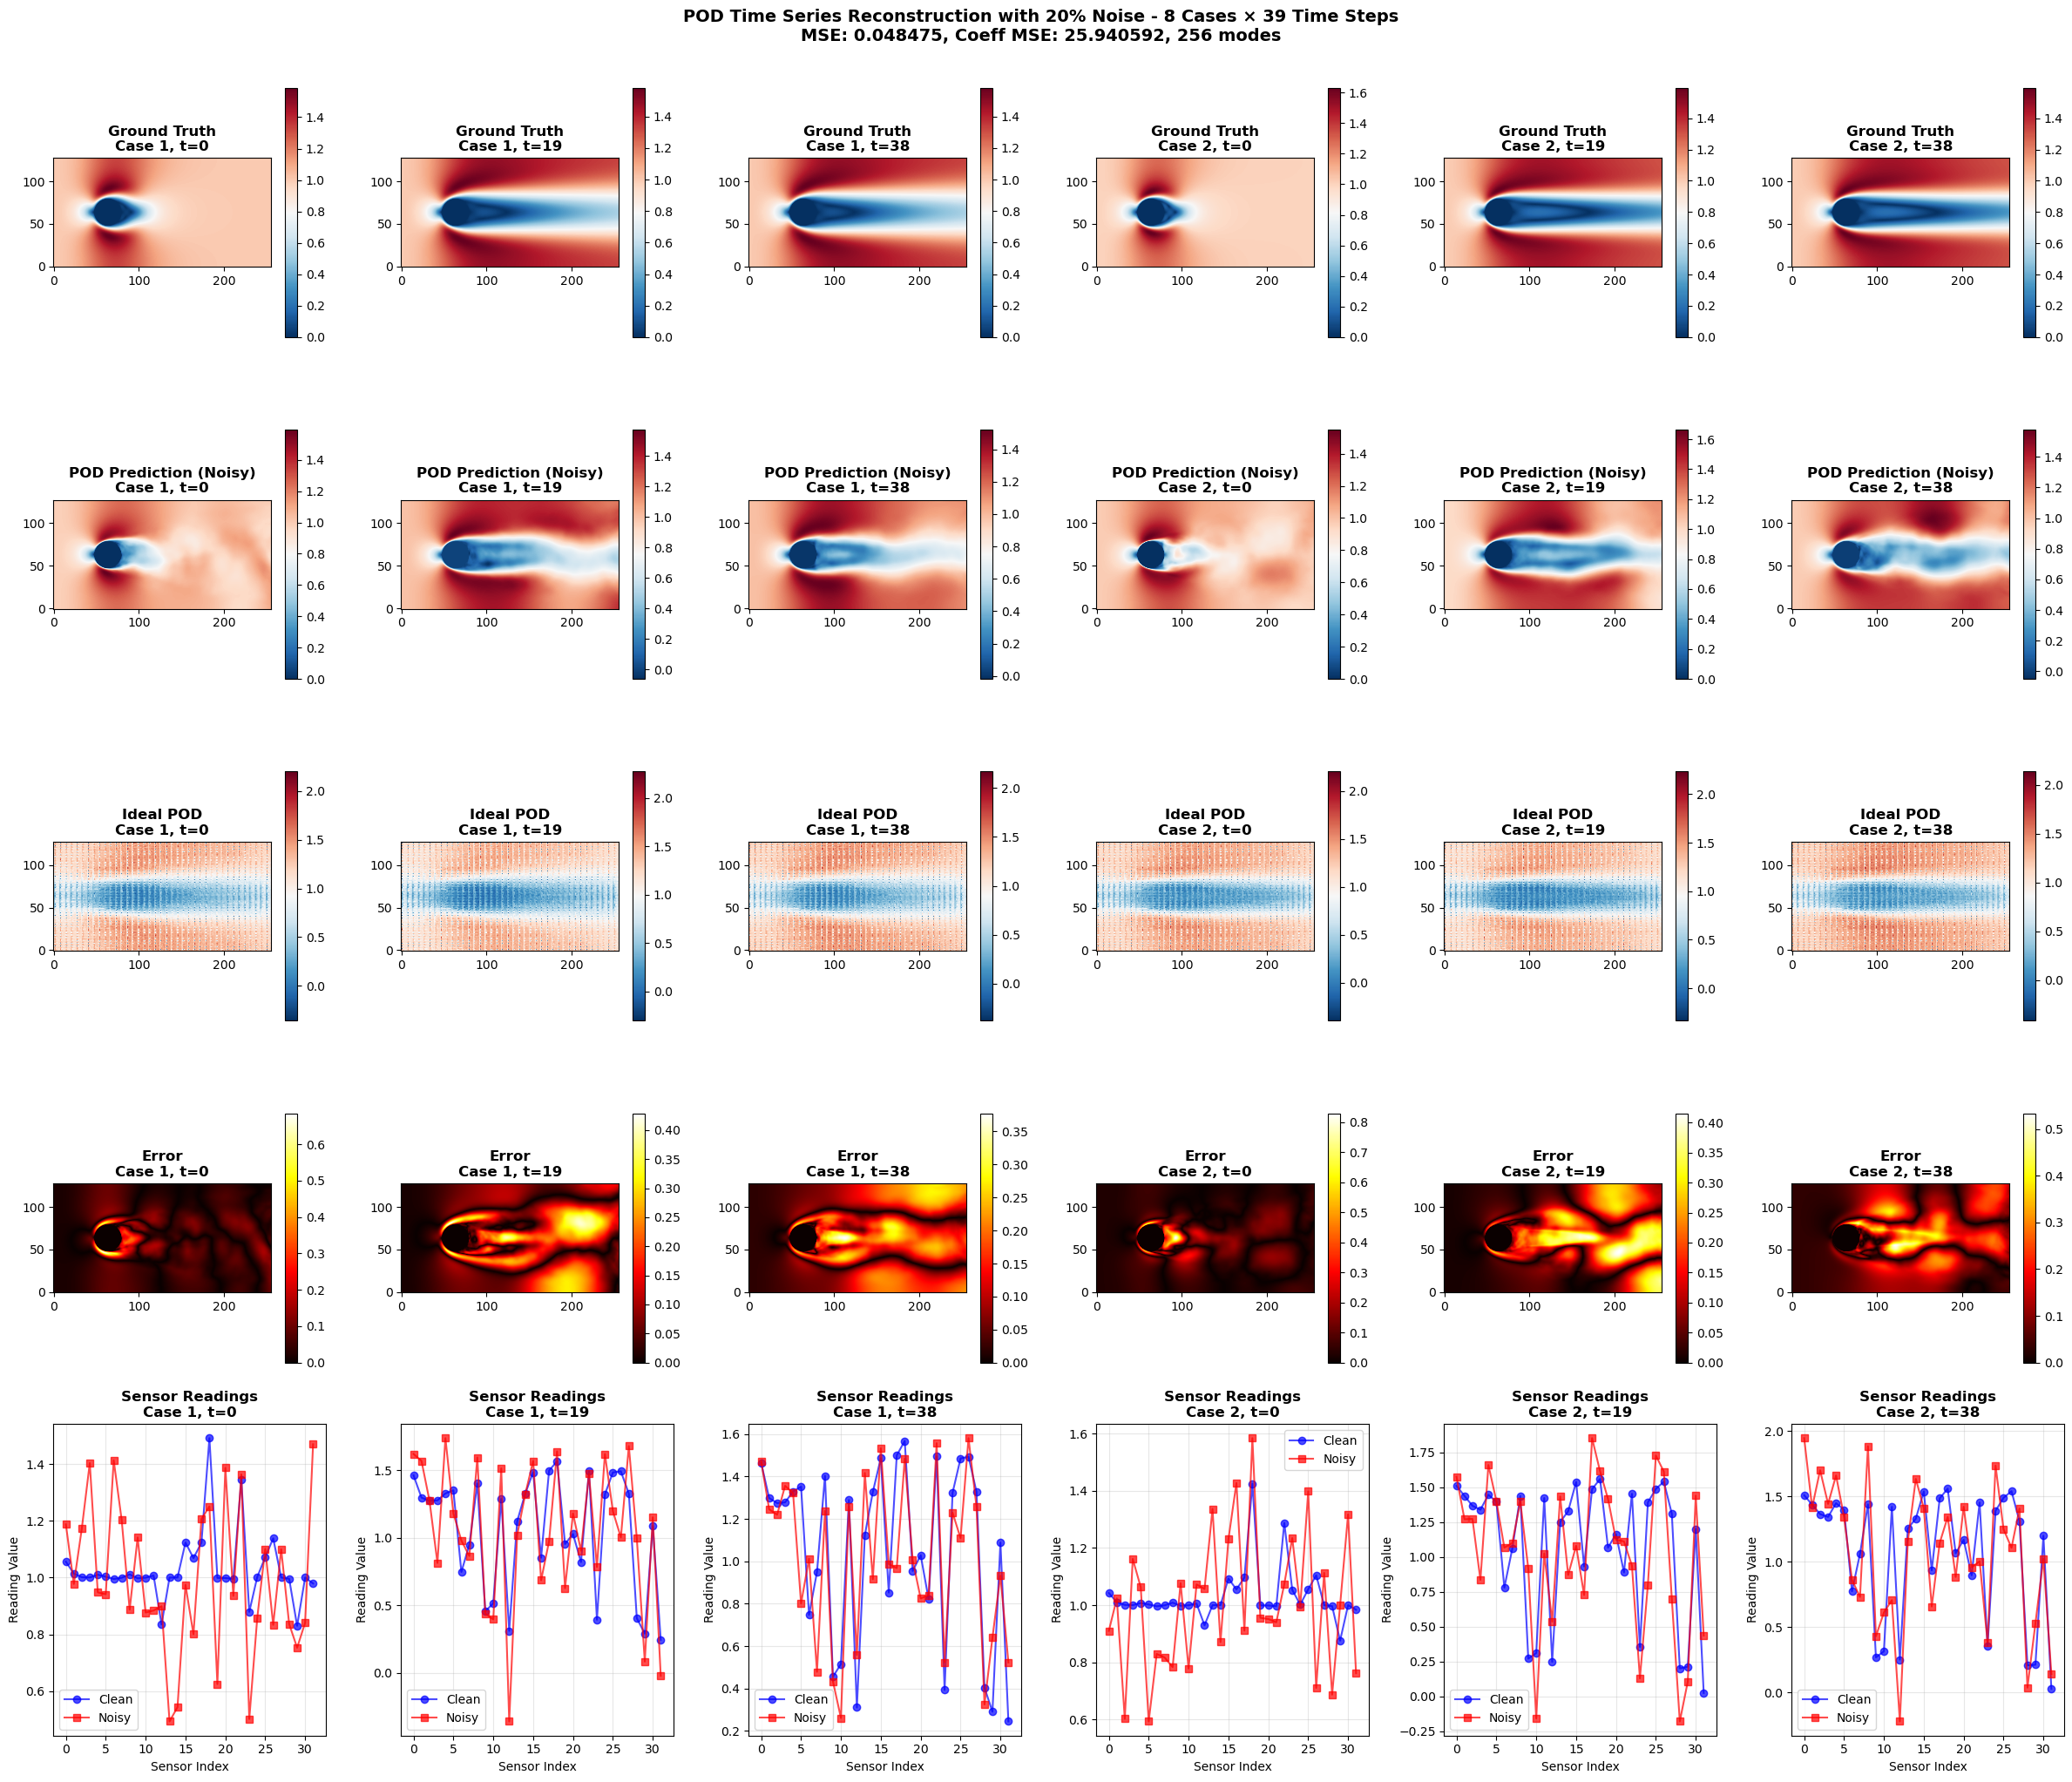


🎉 POD noisy time series inference completed successfully!
   📊 Final output: (8, 128, 256, 39)
   🔊 Noise: ENABLED
   📈 Noise level: 20% (SNR: 1.93 dB)
   📈 Performance degradation: 64.93%
   📈 Field MSE: 0.04847540
   📈 Coefficient MSE: 25.94059181
   🔗 Field Correlation: 0.851508
   🔗 Coefficient Correlation: 0.923102
   📊 Compression: 128.0x (256 modes)
   ⏱️  Total time: 1.38s



In [16]:
# POD Inference on Test Dataset with Noise Support and Custom Reshaping to (8, 128, 256, 39)
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import time

print("🔮 === POD TEST DATASET INFERENCE WITH NOISE ===")
print("=" * 60)

# Configuration for inference
save_results = True  # Set to True to save reconstruction results
visualize_samples = True  # Set to True to show visualizations
n_visualization_samples = 6  # Number of samples to visualize
save_format = 'npz'  # Options: 'npz', 'npy', 'both'
results_dir = Path(config['checkpoint_dir']).parent / "inference_results"

# NOISE CONFIGURATION
add_sensor_noise = True  # Set to True to add noise to sensor data
noise_std_percent = 20  # Noise level as percentage of signal range (5% = moderate noise)
noise_seed = 42  # Seed for reproducible noise generation
save_noise_info = True  # Save noise parameters and clean/noisy sensor data

# Target reshape dimensions - FIXED DIMENSIONS
TARGET_CASES = 8
TARGET_HEIGHT = 128
TARGET_WIDTH = 256
TARGET_TIME = 39

print(f"🎯 Target reshape: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
print(f"🔊 Noise settings: {'Enabled' if add_sensor_noise else 'Disabled'}")
if add_sensor_noise:
    print(f"   Noise level: {noise_std_percent}% of signal range")
    print(f"   Noise seed: {noise_seed}")
    print(f"   Save noise info: {'Yes' if save_noise_info else 'No'}")

def add_gaussian_noise_to_sensors(sensor_data, noise_std_percent=5.0, seed=None):
    """
    Add Gaussian noise to sensor data
    
    Args:
        sensor_data: Input sensor data array
        noise_std_percent: Standard deviation as percentage of signal range
        seed: Random seed for reproducibility
    
    Returns:
        noisy_sensor_data: Sensor data with added noise
        noise_stats: Dictionary with noise statistics
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Calculate signal statistics
    signal_min = np.min(sensor_data)
    signal_max = np.max(sensor_data)
    signal_range = signal_max - signal_min
    signal_std = np.std(sensor_data)
    
    # Calculate noise standard deviation
    noise_std = (noise_std_percent / 100.0) * signal_range
    
    # Generate Gaussian noise
    noise = np.random.normal(0, noise_std, sensor_data.shape)
    
    # Add noise to sensor data
    noisy_sensor_data = sensor_data + noise
    
    # Calculate noise statistics (fix the circular reference)
    noise_actual_std = np.std(noise)
    snr_db = 20 * np.log10(signal_std / noise_actual_std) if noise_actual_std > 0 else float('inf')
    
    noise_stats = {
        'noise_std_percent': noise_std_percent,
        'noise_std_absolute': noise_std,
        'signal_range': signal_range,
        'signal_std': signal_std,
        'signal_min': signal_min,
        'signal_max': signal_max,
        'noise_min': np.min(noise),
        'noise_max': np.max(noise),
        'noise_mean': np.mean(noise),
        'noise_actual_std': noise_actual_std,
        'snr_db': snr_db,
        'seed': seed
    }
    
    print(f"   📊 Noise Statistics:")
    print(f"      Signal range: [{signal_min:.6f}, {signal_max:.6f}]")
    print(f"      Signal std: {signal_std:.6f}")
    print(f"      Noise std (target): {noise_std:.6f}")
    print(f"      Noise std (actual): {noise_actual_std:.6f}")
    print(f"      SNR: {snr_db:.2f} dB")
    
    return noisy_sensor_data, noise_stats

# Create results directory
if save_results:
    results_dir.mkdir(exist_ok=True)
    print(f"📁 Results will be saved to: {results_dir}")

# Check if POD model is available
if 'loaded_pod_model' in locals() and loaded_pod_model is not None:
    pod_model_for_inference = loaded_pod_model
    pod_modes_for_inference = loaded_pod_modes
    print(f"✅ Using loaded POD model for inference")
elif 'pod_model' in locals() and pod_model is not None:
    pod_model_for_inference = pod_model
    pod_modes_for_inference = pod_modes
    print(f"✅ Using trained POD model for inference")
else:
    print("❌ POD model not available!")
    print("   Please load or train the POD model first")
    pod_model_for_inference = None

if pod_model_for_inference is not None:
    print(f"   Model type: POD-based (Sensor → POD coefficients → Field)")
    print(f"   Configuration: {n_sensors} sensors → {n_pod_modes} POD modes")
    print(f"   Compression ratio: {np.prod(input_shape) / n_pod_modes:.1f}x")

    # Load test dataset similar to MLP/FLRNet approach
    print(f"\n📂 Loading test dataset...")
    
    # Create test dataset path by adding 'test_' prefix to the filename
    test_dataset_path = str(Path(config['dataset_path']).parent / f"test_{Path(config['dataset_path']).name}")
    print(f"📁 Test dataset path: {test_dataset_path}")

    # Check if test dataset exists
    if not Path(test_dataset_path).exists():
        print(f"❌ Test dataset not found: {test_dataset_path}")
        print("⚠️  Using training data split instead")
        
        # Use existing training datasets
        test_dataset_for_inference = coord_test_dataset
        test_sensor_positions = sensor_positions
        
    else:
        # Load the test dataset directly from the NPZ file
        print(f"📁 Loading test dataset file...")
        test_data = np.load(test_dataset_path)

        # Create test dataset dictionary (only essential keys)
        essential_keys = ['field_data', 'sensor_data', 'sensor_positions']
        test_dataset_dict = {}
        for key in essential_keys:
            if key in test_data:
                test_dataset_dict[key] = test_data[key]
            else:
                print(f"⚠️  Missing key '{key}' in test dataset")

        # Print basic test dataset information
        print(f"📊 Test dataset loaded:")
        for key, value in test_dataset_dict.items():
            if isinstance(value, np.ndarray):
                print(f"   {key}: {value.shape}")

        # Extract test sensor positions
        test_sensor_positions = test_dataset_dict.get('sensor_positions', sensor_positions)

        # Create TensorFlow test datasets
        print(f"📊 Creating TensorFlow test datasets...")
        
        # Limit test dataset size for faster processing
        max_test_samples = min(1000, len(test_dataset_dict['field_data']))
        
        # Create smaller test dataset dictionary
        limited_test_dataset = {}
        for key, value in test_dataset_dict.items():
            if isinstance(value, np.ndarray) and len(value) > max_test_samples:
                limited_test_dataset[key] = value[:max_test_samples]
            else:
                limited_test_dataset[key] = value
        
        print(f"   Limited to {max_test_samples} samples for performance")
        
        # Use smaller batch size for test data
        test_batch_size = min(16, batch_size)
        
        test_train_dataset, test_test_dataset = creator.create_tensorflow_dataset(
            limited_test_dataset,
            batch_size=test_batch_size,
            shuffle=False,  # Don't shuffle test data
            test_split=1.0
        )

        # Add coordinate grids to test datasets
        test_coord_train_dataset = test_train_dataset.map(add_coordinate_grid)
        test_coord_test_dataset = test_test_dataset.map(add_coordinate_grid)

        # Use the test dataset for inference
        test_dataset_for_inference = test_coord_test_dataset

    # Initialize storage for results
    all_predictions = []
    all_targets = []
    all_sensor_data = []
    all_clean_sensor_data = []  # Store original clean sensor data
    all_predicted_coefficients = []
    all_noise_data = []  # Store the actual noise added
    
    # Performance tracking
    inference_times = []
    batch_mses = []
    batch_mses_noise = []  # MSE with noise comparison
    
    # Global noise statistics
    noise_stats_global = None
    
    print(f"\n🔮 Starting {'noisy' if add_sensor_noise else 'clean'} POD inference on test dataset...")
    start_time = time.time()
    
    # Process all batches
    batch_count = 0
    for batch_idx, batch in enumerate(test_dataset_for_inference):
        batch_start_time = time.time()
        
        # Extract sensor and field data
        sensor_data = batch['sensor_data']
        field_data = batch['field_data']
        
        # Store clean sensor data
        clean_sensor_data = sensor_data.numpy()
        all_clean_sensor_data.append(clean_sensor_data)
        
        # Add noise to sensor data if enabled
        if add_sensor_noise:
            # Apply noise
            noisy_sensor_data_np, batch_noise_stats = add_gaussian_noise_to_sensors(
                clean_sensor_data, 
                noise_std_percent=noise_std_percent, 
                seed=noise_seed + batch_idx  # Different seed per batch
            )
            
            # Store noise statistics from first batch
            if noise_stats_global is None:
                noise_stats_global = batch_noise_stats
                print(f"   🔊 Global noise statistics captured from first batch")
            
            # Convert back to tensor for POD inference
            sensor_data_for_inference = tf.constant(noisy_sensor_data_np, dtype=tf.float32)
            
            # Store the noisy sensor data and actual noise
            all_sensor_data.append(noisy_sensor_data_np)
            noise_added = noisy_sensor_data_np - clean_sensor_data
            all_noise_data.append(noise_added)
        else:
            # Use clean sensor data
            sensor_data_for_inference = sensor_data
            all_sensor_data.append(clean_sensor_data)
        
        # POD inference - sensor to field via POD coefficients
        field_predictions = pod_model_for_inference(sensor_data_for_inference, training=False)
        
        # Also get POD coefficients for analysis
        predicted_coefficients = pod_model_for_inference.predict_coefficients(sensor_data_for_inference)
        
        # Store results
        all_predictions.append(field_predictions.numpy())
        all_targets.append(field_data.numpy())
        all_predicted_coefficients.append(predicted_coefficients.numpy())
        
        # Calculate batch metrics
        batch_mse = np.mean((field_data.numpy() - field_predictions.numpy()) ** 2)
        batch_mses.append(batch_mse)
        
        # Calculate noise impact if applicable
        if add_sensor_noise:
            # Also test with clean sensors for comparison
            clean_predictions = pod_model_for_inference(sensor_data, training=False)
            clean_mse = np.mean((field_data.numpy() - clean_predictions.numpy()) ** 2)
            noise_impact = batch_mse - clean_mse
            batch_mses_noise.append(noise_impact)
        
        # Track timing
        batch_time = time.time() - batch_start_time
        inference_times.append(batch_time)
        
        batch_count += 1
        
        # Progress update
        if batch_count % 5 == 0 or batch_count == 1:
            avg_time = np.mean(inference_times[-5:])
            noise_label = "NOISY" if add_sensor_noise else "CLEAN"
            noise_info = f", Noise Impact: +{np.mean(batch_mses_noise[-5:]):.6f}" if add_sensor_noise and batch_mses_noise else ""
            print(f"   Batch {batch_count} [{noise_label}] - "
                  f"MSE: {batch_mse:.6f}{noise_info}, "
                  f"Time: {batch_time:.3f}s, "
                  f"Avg: {avg_time:.3f}s/batch")
    
    total_time = time.time() - start_time
    
    # Concatenate all results
    print(f"\n📦 Consolidating results...")
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    all_sensor_data = np.concatenate(all_sensor_data, axis=0)  # This is noisy if noise was added
    all_clean_sensor_data = np.concatenate(all_clean_sensor_data, axis=0)  # Always clean
    all_predicted_coefficients = np.concatenate(all_predicted_coefficients, axis=0)
    
    if add_sensor_noise and all_noise_data:
        all_noise_data = np.concatenate(all_noise_data, axis=0)
    
    # CUSTOM RESHAPE TO (8, 128, 256, 39) FORMAT
    print(f"\n🔄 Reshaping data to target format ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})...")
    
    # Get original shapes
    original_samples, height, width, n_channels = all_predictions.shape
    print(f"   Original shape: {all_predictions.shape}")
    print(f"   Available samples: {original_samples}")
    print(f"   Required samples: {TARGET_CASES * TARGET_TIME} ({TARGET_CASES} × {TARGET_TIME})")
    
    # Calculate how many samples we need
    required_samples = TARGET_CASES * TARGET_TIME
    
    if original_samples >= required_samples:
        print(f"   ✅ Sufficient samples available")
        
        # Take exactly the number of samples we need
        predictions_subset = all_predictions[:required_samples]
        targets_subset = all_targets[:required_samples]
        sensor_data_subset = all_sensor_data[:required_samples]  # Noisy or clean depending on settings
        clean_sensor_data_subset = all_clean_sensor_data[:required_samples]  # Always clean
        coefficients_subset = all_predicted_coefficients[:required_samples]
        
        # Reshape from (312, 128, 256, 1) to (8, 39, 128, 256, 1)
        predictions_grouped = predictions_subset.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        targets_grouped = targets_subset.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        
        # Transpose to (8, 128, 256, 39, 1) then squeeze to (8, 128, 256, 39)
        predictions_reshaped = np.transpose(predictions_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        targets_reshaped = np.transpose(targets_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        
        # Reshape sensor data to (8, 39, n_sensors)
        sensor_data_reshaped = sensor_data_subset.reshape(TARGET_CASES, TARGET_TIME, -1)
        clean_sensor_data_reshaped = clean_sensor_data_subset.reshape(TARGET_CASES, TARGET_TIME, -1)
        
        # Reshape POD coefficients to (8, 39, n_pod_modes)
        coefficients_reshaped = coefficients_subset.reshape(TARGET_CASES, TARGET_TIME, -1)
        
        # Handle noise data if available
        if add_sensor_noise and all_noise_data.size > 0:
            noise_subset = all_noise_data[:required_samples]
            noise_reshaped = noise_subset.reshape(TARGET_CASES, TARGET_TIME, -1)
        else:
            noise_reshaped = None
        
        print(f"   ✅ Successfully reshaped to target format:")
        print(f"      - Predictions: {predictions_reshaped.shape} (case, height, width, time)")
        print(f"      - Targets: {targets_reshaped.shape} (case, height, width, time)")
        print(f"      - Sensor data ({'noisy' if add_sensor_noise else 'clean'}): {sensor_data_reshaped.shape} (case, time, sensors)")
        print(f"      - Clean sensor data: {clean_sensor_data_reshaped.shape} (case, time, sensors)")
        print(f"      - POD coefficients: {coefficients_reshaped.shape} (case, time, modes)")
        if noise_reshaped is not None:
            print(f"      - Noise data: {noise_reshaped.shape} (case, time, sensors)")
    
    else:
        print(f"   ⚠️  Insufficient samples: {original_samples} < {required_samples}")
        print(f"   🔄 Padding with zeros to reach target dimensions...")
        
        # Calculate padding needed
        padding_needed = required_samples - original_samples
        
        # Pad predictions and targets
        padding_shape_pred = (padding_needed, height, width, n_channels)
        predictions_padded = np.concatenate([all_predictions, np.zeros(padding_shape_pred)], axis=0)
        targets_padded = np.concatenate([all_targets, np.zeros(padding_shape_pred)], axis=0)
        
        # Pad sensor data
        padding_shape_sensor = (padding_needed, all_sensor_data.shape[1])
        sensor_data_padded = np.concatenate([all_sensor_data, np.zeros(padding_shape_sensor)], axis=0)
        clean_sensor_data_padded = np.concatenate([all_clean_sensor_data, np.zeros(padding_shape_sensor)], axis=0)
        
        # Pad coefficients
        padding_shape_coeff = (padding_needed, all_predicted_coefficients.shape[1])
        coefficients_padded = np.concatenate([all_predicted_coefficients, np.zeros(padding_shape_coeff)], axis=0)
        
        # Reshape padded data
        predictions_grouped = predictions_padded.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        targets_grouped = targets_padded.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        
        # Transpose to (case, height, width, time)
        predictions_reshaped = np.transpose(predictions_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        targets_reshaped = np.transpose(targets_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        
        # Reshape sensor data and coefficients
        sensor_data_reshaped = sensor_data_padded.reshape(TARGET_CASES, TARGET_TIME, -1)
        clean_sensor_data_reshaped = clean_sensor_data_padded.reshape(TARGET_CASES, TARGET_TIME, -1)
        coefficients_reshaped = coefficients_padded.reshape(TARGET_CASES, TARGET_TIME, -1)
        
        # Handle noise data with padding
        if add_sensor_noise and all_noise_data.size > 0:
            padding_shape_noise = (padding_needed, all_noise_data.shape[1])
            noise_padded = np.concatenate([all_noise_data, np.zeros(padding_shape_noise)], axis=0)
            noise_reshaped = noise_padded.reshape(TARGET_CASES, TARGET_TIME, -1)
        else:
            noise_reshaped = None
        
        print(f"   ✅ Padded and reshaped to: {predictions_reshaped.shape}")
    
    # Verify final shapes match target exactly
    expected_shape = (TARGET_CASES, TARGET_HEIGHT, TARGET_WIDTH, TARGET_TIME)
    if predictions_reshaped.shape == expected_shape:
        print(f"   🎯 Perfect shape match: {predictions_reshaped.shape}")
    else:
        print(f"   ⚠️  Shape mismatch: got {predictions_reshaped.shape}, expected {expected_shape}")
    
    # Calculate POD-specific metrics
    print(f"\n🔍 POD-specific analysis...")
    
    # Compute true POD coefficients for comparison
    test_field_flat = targets_reshaped.reshape(-1, np.prod(input_shape))
    true_coefficients_flat = np.matmul(test_field_flat, pod_modes_for_inference)
    
    # Reshape true coefficients correctly for time series structure
    total_time_samples = TARGET_CASES * TARGET_TIME
    true_coefficients_time_series = true_coefficients_flat.reshape(total_time_samples, n_pod_modes)
    
    # Calculate metrics on the reshaped data
    overall_mse = np.mean((targets_reshaped - predictions_reshaped) ** 2)
    overall_mae = np.mean(np.abs(targets_reshaped - predictions_reshaped))
    overall_rmse = np.sqrt(overall_mse)
    max_error = np.max(np.abs(targets_reshaped - predictions_reshaped))
    correlation = np.corrcoef(targets_reshaped.flatten(), predictions_reshaped.flatten())[0, 1]
    
    # POD coefficient metrics - compare with reshaped coefficient predictions
    coefficients_flat_comparison = coefficients_reshaped.reshape(-1, n_pod_modes)
    coeff_mse = np.mean((true_coefficients_time_series - coefficients_flat_comparison) ** 2)
    coeff_mae = np.mean(np.abs(true_coefficients_time_series - coefficients_flat_comparison))
    coeff_correlation = np.corrcoef(true_coefficients_time_series.flatten(), coefficients_flat_comparison.flatten())[0, 1]
    
    # Ideal POD reconstruction (using true coefficients)
    ideal_reconstruction = np.matmul(true_coefficients_flat, pod_modes_for_inference.T)
    ideal_reconstruction = ideal_reconstruction.reshape(targets_reshaped.shape)
    ideal_mse = np.mean((targets_reshaped - ideal_reconstruction) ** 2)
    
    # Calculate noise impact metrics if applicable
    noise_impact_metrics = {}
    if add_sensor_noise and len(batch_mses_noise) > 0:
        noise_impact_mse = np.mean(batch_mses_noise)
        noise_impact_percentage = (noise_impact_mse / overall_mse) * 100 if overall_mse > 0 else 0
        
        # Sensor data noise analysis
        sensor_noise_snr = noise_stats_global['snr_db'] if noise_stats_global else 0
        sensor_noise_mse = np.mean((clean_sensor_data_reshaped - sensor_data_reshaped) ** 2)
        sensor_noise_mae = np.mean(np.abs(clean_sensor_data_reshaped - sensor_data_reshaped))
        
        noise_impact_metrics = {
            'noise_impact_mse': noise_impact_mse,
            'noise_impact_percentage': noise_impact_percentage,
            'sensor_snr_db': sensor_noise_snr,
            'sensor_noise_mse': sensor_noise_mse,
            'sensor_noise_mae': sensor_noise_mae,
            'noise_std_percent': noise_std_percent
        }
    
    print(f"\n📊 POD INFERENCE RESULTS SUMMARY:")
    print(f"   Output format: (case, height, width, time) = ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
    print(f"   Noise status: {'ENABLED' if add_sensor_noise else 'DISABLED'}")
    if add_sensor_noise:
        print(f"   Noise level: {noise_std_percent}% (SNR: {noise_stats_global['snr_db']:.2f} dB)")
    print(f"   Total inference time: {total_time:.2f}s")
    print(f"   POD modes used: {n_pod_modes}")
    print(f"   Compression ratio: {np.prod(input_shape) / n_pod_modes:.1f}x")
    
    if add_sensor_noise and noise_impact_metrics:
        print(f"\n🔊 NOISE IMPACT ANALYSIS:")
        print(f"   Noise level: {noise_std_percent}% of sensor signal range")
        print(f"   Sensor SNR: {noise_impact_metrics['sensor_snr_db']:.2f} dB")
        print(f"   MSE increase due to noise: {noise_impact_metrics['noise_impact_mse']:.8f}")
        print(f"   Relative performance degradation: {noise_impact_metrics['noise_impact_percentage']:.2f}%")
        print(f"   Sensor noise MSE: {noise_impact_metrics['sensor_noise_mse']:.8f}")
        print(f"   Sensor noise MAE: {noise_impact_metrics['sensor_noise_mae']:.6f}")
    
    print(f"\n📈 FIELD RECONSTRUCTION METRICS:")
    print(f"   MSE: {overall_mse:.8f}")
    print(f"   RMSE: {overall_rmse:.6f}")
    print(f"   MAE: {overall_mae:.6f}")
    print(f"   Max Error: {max_error:.6f}")
    print(f"   Correlation: {correlation:.6f}")
    
    print(f"\n📈 POD COEFFICIENT METRICS:")
    print(f"   Coefficient MSE: {coeff_mse:.8f}")
    print(f"   Coefficient MAE: {coeff_mae:.6f}")
    print(f"   Coefficient Correlation: {coeff_correlation:.6f}")
    
    print(f"\n📈 POD ANALYSIS:")
    print(f"   Ideal POD MSE (theoretical limit): {ideal_mse:.8f}")
    print(f"   Actual model MSE: {overall_mse:.8f}")
    print(f"   MSE ratio (model/ideal): {overall_mse/ideal_mse:.2f}")
    
    # Save results if requested
    if save_results:
        print(f"\n💾 Saving {'noisy' if add_sensor_noise else 'clean'} POD time series results in format ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})...")
        
        # Create comprehensive results dictionary
        results_dict = {
            # Main results in target format
            'predictions': predictions_reshaped,  # Shape: (8, 128, 256, 39)
            'targets': targets_reshaped,          # Shape: (8, 128, 256, 39)
            'sensor_data': sensor_data_reshaped,  # Shape: (8, 39, n_sensors) - noisy if noise enabled
            'clean_sensor_data': clean_sensor_data_reshaped,  # Shape: (8, 39, n_sensors) - always clean
            'pod_coefficients': coefficients_reshaped,  # Shape: (8, 39, n_pod_modes)
            'sensor_positions': test_sensor_positions, # Shape: (n_sensors, 2)
            
            # POD-specific data
            'pod_modes': pod_modes_for_inference,  # Shape: (height*width, n_pod_modes)
            'true_coefficients': true_coefficients_time_series.reshape(TARGET_CASES, TARGET_TIME, n_pod_modes),  # Shape: (8, 39, n_pod_modes)
            'ideal_reconstruction': ideal_reconstruction,     # Shape: (8, 128, 256, 39)
            
            # Shape information
            'shape_info': {
                'n_cases': TARGET_CASES,
                'height': TARGET_HEIGHT,
                'width': TARGET_WIDTH,
                'time_steps': TARGET_TIME,
                'n_sensors': n_sensors,
                'n_pod_modes': n_pod_modes,
                'compression_ratio': float(np.prod(input_shape) / n_pod_modes),
                'format': f'({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})',
                'description': f'{TARGET_CASES} cases with {TARGET_TIME} time steps each'
            },
            
            # Metrics and configuration
            'metrics': {
                'field_mse': overall_mse,
                'field_rmse': overall_rmse,
                'field_mae': overall_mae,
                'field_max_error': max_error,
                'field_correlation': correlation,
                'coeff_mse': coeff_mse,
                'coeff_mae': coeff_mae,
                'coeff_correlation': coeff_correlation,
                'ideal_mse': ideal_mse,
                'mse_ratio': float(overall_mse/ideal_mse)
            },
            
            'config': {
                'model_name': model_name,
                'n_sensors': n_sensors,
                'n_pod_modes': n_pod_modes,
                'model_type': 'POD',
                'input_shape': input_shape,
                'hidden_layers': pod_config['hidden_layers'],
                'activation': pod_config['activation'],
                'dropout_rate': pod_config['dropout_rate'],
                'use_batch_norm': pod_config['use_batch_norm']
            },
            
            'inference_info': {
                'total_cases': TARGET_CASES,
                'time_steps': TARGET_TIME,
                'total_time': total_time,
                'noise_enabled': add_sensor_noise,
                'timestamp': time.strftime('%Y%m%d_%H%M%S')
            }
        }
        
        # Add noise information if noise was applied
        if add_sensor_noise and noise_stats_global is not None:
            results_dict['noise_info'] = noise_stats_global
            results_dict['metrics'].update(noise_impact_metrics)
            
            # Add actual noise data if requested
            if save_noise_info and noise_reshaped is not None:
                results_dict['noise_data'] = noise_reshaped  # Shape: (8, 39, n_sensors)
        
        # Generate filename with noise info
        noise_suffix = f"_noise{noise_std_percent:.0f}p" if add_sensor_noise else "_clean"
        filename_base = f"pod_{config_name}{noise_suffix}"

        # Save as NPZ
        npz_path = results_dir / f"{filename_base}.npz"
        np.savez_compressed(npz_path, **results_dict)
        print(f"   ✅ Results saved: {npz_path}")
        print(f"      - Predictions: {predictions_reshaped.shape}")
        print(f"      - Targets: {targets_reshaped.shape}")
        print(f"      - Sensor data ({'noisy' if add_sensor_noise else 'clean'}): {sensor_data_reshaped.shape}")
        print(f"      - Clean sensor data: {clean_sensor_data_reshaped.shape}")
        print(f"      - POD coefficients: {coefficients_reshaped.shape}")
        print(f"      - POD modes: {pod_modes_for_inference.shape}")
        if add_sensor_noise and save_noise_info and noise_reshaped is not None:
            print(f"      - Noise data: {noise_reshaped.shape}")
        print(f"      - Format: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
    
    # Enhanced visualization for time series data with noise comparison
    if visualize_samples:
        print(f"\n🎨 Creating {'noisy' if add_sensor_noise else 'clean'} POD time series visualization...")
        
        # Visualize first few cases and time steps
        n_cases_to_show = min(2, TARGET_CASES)
        n_times_to_show = min(3, TARGET_TIME)
        
        if add_sensor_noise:
            # Enhanced visualization with noise analysis
            fig, axes = plt.subplots(5, n_cases_to_show * n_times_to_show, 
                                    figsize=(4 * n_cases_to_show * n_times_to_show, 20))
        else:
            # Standard visualization
            fig, axes = plt.subplots(4, n_cases_to_show * n_times_to_show, 
                                    figsize=(4 * n_cases_to_show * n_times_to_show, 16))
        
        if axes.ndim == 1:
            axes = axes.reshape(-1, -1)
        
        plot_idx = 0
        for case_idx in range(n_cases_to_show):
            # Show evenly spaced time steps
            time_indices = np.linspace(0, TARGET_TIME-1, n_times_to_show, dtype=int)
            
            for t_idx in time_indices:
                if plot_idx < axes.shape[1]:
                    # Ground truth
                    im1 = axes[0, plot_idx].imshow(targets_reshaped[case_idx, :, :, t_idx], 
                                                  cmap='RdBu_r', origin='lower')
                    axes[0, plot_idx].set_title(f'Ground Truth\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
                    plt.colorbar(im1, ax=axes[0, plot_idx], shrink=0.8)
                    
                    # POD prediction
                    im2 = axes[1, plot_idx].imshow(predictions_reshaped[case_idx, :, :, t_idx], 
                                                  cmap='RdBu_r', origin='lower')
                    noise_label = f" ({'Noisy' if add_sensor_noise else 'Clean'})"
                    axes[1, plot_idx].set_title(f'POD Prediction{noise_label}\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
                    plt.colorbar(im2, ax=axes[1, plot_idx], shrink=0.8)
                    
                    # Ideal POD reconstruction
                    im3 = axes[2, plot_idx].imshow(ideal_reconstruction[case_idx, :, :, t_idx], 
                                                  cmap='RdBu_r', origin='lower')
                    axes[2, plot_idx].set_title(f'Ideal POD\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
                    plt.colorbar(im3, ax=axes[2, plot_idx], shrink=0.8)
                    
                    # Error
                    error = np.abs(targets_reshaped[case_idx, :, :, t_idx] - 
                                  predictions_reshaped[case_idx, :, :, t_idx])
                    im4 = axes[3, plot_idx].imshow(error, cmap='hot', origin='lower')
                    axes[3, plot_idx].set_title(f'Error\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
                    plt.colorbar(im4, ax=axes[3, plot_idx], shrink=0.8)
                    
                    # Additional noise visualization if enabled
                    if add_sensor_noise and axes.shape[0] > 4:
                        # Show sensor noise impact visualization
                        sensor_clean_vals = clean_sensor_data_reshaped[case_idx, t_idx, :]
                        sensor_noisy_vals = sensor_data_reshaped[case_idx, t_idx, :]
                        
                        # Create a simple sensor comparison plot
                        ax_noise = axes[4, plot_idx]
                        sensor_indices = np.arange(len(sensor_clean_vals))
                        ax_noise.plot(sensor_indices, sensor_clean_vals, 'b-o', label='Clean', alpha=0.7)
                        ax_noise.plot(sensor_indices, sensor_noisy_vals, 'r-s', label='Noisy', alpha=0.7)
                        ax_noise.set_title(f'Sensor Readings\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
                        ax_noise.set_xlabel('Sensor Index')
                        ax_noise.set_ylabel('Reading Value')
                        ax_noise.legend()
                        ax_noise.grid(True, alpha=0.3)
                    
                    plot_idx += 1
        
        plt.tight_layout()
        noise_title = f" with {noise_std_percent}% Noise" if add_sensor_noise else " (Clean)"
        plt.suptitle(f'POD Time Series Reconstruction{noise_title} - {TARGET_CASES} Cases × {TARGET_TIME} Time Steps\n'
                    f'MSE: {overall_mse:.6f}, Coeff MSE: {coeff_mse:.6f}, {n_pod_modes} modes', 
                    y=1.02, fontsize=14, fontweight='bold')
        plt.show()
    
    print(f"\n🎉 POD {'noisy' if add_sensor_noise else 'clean'} time series inference completed successfully!")
    print(f"   📊 Final output: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
    print(f"   🔊 Noise: {'ENABLED' if add_sensor_noise else 'DISABLED'}")
    if add_sensor_noise:
        print(f"   📈 Noise level: {noise_std_percent}% (SNR: {noise_stats_global['snr_db']:.2f} dB)")
        print(f"   📈 Performance degradation: {noise_impact_metrics.get('noise_impact_percentage', 0):.2f}%")
    print(f"   📈 Field MSE: {overall_mse:.8f}")
    print(f"   📈 Coefficient MSE: {coeff_mse:.8f}")
    print(f"   🔗 Field Correlation: {correlation:.6f}")
    print(f"   🔗 Coefficient Correlation: {coeff_correlation:.6f}")
    print(f"   📊 Compression: {np.prod(input_shape) / n_pod_modes:.1f}x ({n_pod_modes} modes)")
    print(f"   ⏱️  Total time: {total_time:.2f}s")

print(f"\n" + "=" * 60)